<a href="https://colab.research.google.com/github/gianghuong13/Rain-Classification/blob/main/Code/RainClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tổng hợp code sử dụng trong bài toán phân loại mưa

##I. Xử lí dữ liệu

1. Xử lý và kết hợp dữ liệu từ ba nguồn (ERA5, HIMA và AWS) cho từng ngày trong từng tháng (04/ 2019, 10/2019, 04/2020, 10/2020), sau đó lưu kết quả vào các tệp CSV riêng biệt cho mỗi ngày. Đọc dữ liệu từ tệp .tif, xử lý giá trị NaN (không có dữ liệu), đọc và xử lý dữ liệu từ thư mục, lọc dữ liệu theo ngày và
biến, và lưu chúng vào một dictionary theo dạng (timestamp, row, col)



In [ ]:
# data in 31 days
# tạo từng file cho mỗi ngày
import os
import glob
import rasterio
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Đường dẫn gốc của các thư mục chứa dữ liệu
path_era5 = '/content/drive/MyDrive/AI_PROJECT/DATASET/ERA5'
path_hima = '/content/drive/MyDrive/AI_PROJECT/DATASET/Hima'
path_aws = '/content/drive/MyDrive/AI_PROJECT/DATASET/Precipitation/AWS'

# Các biến quan trọng từ ERA5 và HIMA đã chọn
era5_vars = ['CAPE','R250', 'R500', 'R850', 'TCWV', 'U850', 'V850' ]
hima_vars = ['B04B', 'B05B', 'B06B', 'B09B', 'B10B', 'B11B', 'B12B', 'IRB', 'WVB']

# Ngày bắt đầu và kết thúc để lọc dữ liệu
start_date = datetime(2019, 10, 1)
end_date = datetime(2019, 10, 31)

def get_timestamp(filename, file_type):
    if file_type in ['AWS', 'ERA5']:
        timestamp_str = filename.split('_')[-1][:10]
    elif file_type == 'Hima':
        date_str, hour_str = extract_date_and_hour(filename)
        timestamp_str = f"{date_str}{hour_str}"

    if not timestamp_str:
        raise ValueError(f"No valid timestamp found in filename: {filename}")

    try:
        timestamp = datetime.strptime(timestamp_str, "%Y%m%d%H")
    except ValueError as e:
        raise ValueError(f"Error parsing timestamp '{timestamp_str}' from filename '{filename}': {e}")

    return timestamp

def extract_date_and_hour(filename):
    parts = filename.split('_')
    date_str = parts[1].split('.')[0]
    hour_str = parts[1].split('Z')[1][:2]
    return date_str, hour_str

def read_tif(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)
        data[data == src.nodata] = np.nan
    return data

def process_data(path, variables, file_type, target_date):
    data_dict = {}
    for var in variables:
        var_path = os.path.join(path, var, '**', '*.tif')
        files = glob.glob(var_path, recursive=True)
        for file in files:
            timestamp = get_timestamp(os.path.basename(file), file_type)
            if timestamp.date() == target_date:
                data = read_tif(file)
                rows, cols = np.where(~np.isnan(data))
                values = data[rows, cols]
                for r, c, val in zip(rows, cols, values):
                    data_dict.setdefault((timestamp, r, c), {}).update({var: val})
    return data_dict

# Vòng lặp qua từng ngày trong khoảng thời gian và lưu mỗi ngày vào một tệp CSV
for single_date in pd.date_range(start=start_date, end=end_date):
    target_date = single_date.date()

    # Khởi tạo DataFrame cho từng ngày
    daily_data = pd.DataFrame(columns=['datetime', 'Row', 'Col'] + era5_vars + hima_vars + ['AWS'])

    # Đọc dữ liệu từ ERA5 và HIMA
    era5_data = process_data(path_era5, era5_vars, 'ERA5', target_date)
    hima_data = process_data(path_hima, hima_vars, 'Hima', target_date)

    # Đọc dữ liệu AWS cho ngày hiện tại
    aws_path = os.path.join(path_aws, single_date.strftime('%Y'), single_date.strftime('%m'), single_date.strftime('%d'), '*.tif')
    aws_files = glob.glob(aws_path)
    for file in aws_files:
        timestamp = get_timestamp(os.path.basename(file), 'AWS')
        data = read_tif(file)
        rows, cols = np.where(~np.isnan(data))
        values = data[rows, cols]
        for r, c, val in zip(rows, cols, values):
            aws_key = (timestamp, r, c)
            if aws_key in era5_data and aws_key in hima_data:
                era5_data[aws_key].update({'AWS': val})

    # Hợp nhất dữ liệu từ các dict thành DataFrame cho từng ngày
    rows_to_add = []
    for key in set(era5_data.keys()).intersection(hima_data.keys()):
        if 'AWS' in era5_data[key]:
            timestamp, row, col = key
            combined_row = {'datetime': timestamp, 'Row': row, 'Col': col}
            combined_row.update(era5_data.get(key, {var: np.nan for var in era5_vars}))
            combined_row.update(hima_data.get(key, {var: np.nan for var in hima_vars}))
            combined_row['AWS'] = era5_data[key]['AWS']

            rows_to_add.append(combined_row)

    # Chuyển đổi danh sách thành DataFrame và kết hợp
    daily_data = pd.concat([daily_data, pd.DataFrame(rows_to_add)], ignore_index=True)

    # Chuyển đổi 'datetime' thành kiểu datetime
    daily_data['datetime'] = pd.to_datetime(daily_data['datetime'], errors='coerce')

    # Lưu dữ liệu của ngày hiện tại vào một tệp CSV riêng biệt
    output_file = f"/content/drive/MyDrive/AI_PROJECT/NEWDATA/data_{target_date}.csv"
    daily_data.to_csv(output_file, index=False)
    print(f"Đã lưu dữ liệu cho ngày {target_date} vào tệp {output_file}")


2. Gộp các file riêng biệt ở trên thành 1 file trong 1 tháng

In [ ]:
# merge 31 files into 1 file
import pandas as pd
import glob

# Step 2: Define the directory path and load all CSV files for October
path = '/content/drive/MyDrive/AI_PROJECT/NEWDATA'
all_files = sorted(glob.glob(f"{path}/data_2019-10-*.csv"))

# Step 3: Read and concatenate all files into a single DataFrame
merged_data = pd.concat([pd.read_csv(file) for file in all_files], ignore_index=True)

# Step 4: Save the merged DataFrame to a new CSV file
output_file = f"{path}/data_2019-october.csv"
merged_data.to_csv(output_file, index=False)

print(f"Files merged and saved to: {output_file}")


3. Clean dữ liệu, xóa các hàng có ô bị thiếu, hoặc có giá trị inf, -inf


In [ ]:
# clean data: bỏ các dòng có ô bị thiếu
import pandas as pd
import numpy as np

# Load the merged data file
merged_data_path = '/content/drive/MyDrive/AI_PROJECT/NEWDATA/data_2019.csv'
merged_data = pd.read_csv(merged_data_path)

# Remove rows with NaN or infinite values
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN first
merged_data.dropna(inplace=True)  # Drop rows with NaN values

# Remove rows with specific values like 9999
merged_data = merged_data[(merged_data != 9999).all(axis=1)]

# Save the cleaned DataFrame
cleaned_output_file = '/content/drive/MyDrive/AI_PROJECT/NEWDATA/cleaned_data_2019.csv'
merged_data.to_csv(cleaned_output_file, index=False)

print(f"Cleaned data saved to: {cleaned_output_file}")

4. Merge dữ liệu của năm 2019 và 2020

In [ ]:
import pandas as pd
file1 = '/content/drive/MyDrive/AI_PROJECT/NEWDATA/cleaned_data_2019.csv'
file2 = '/content/drive/MyDrive/AI_PROJECT/NEWDATA/cleaned_data_2020.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

merged_df = pd.concat([df1, df2], axis=0, ignore_index=True)
merged_df.to_csv('/content/drive/MyDrive/AI_PROJECT/NEWDATA/data_all_cleaned.csv', index=False)


##II. Chạy mô hình

###1.Random Forest

a. Sử dụng tham số mặc định

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Đọc dữ liệu và tiền xử lý
df = pd.read_csv("/content/drive/MyDrive/AI_PROJECT/NEWDATA/data_all_cleaned.csv")

# 2. Loại bỏ các cột không cần thiết
df = df.drop(columns=['datetime', 'Row', 'Col'])

# 3. Gán nhãn cho cột AWS
df['label'] = (df['AWS'] > 0).astype(int)

# 4. Chia dữ liệu thành đầu vào (features) và nhãn (target)
X = df.drop(columns=['label', 'AWS'])
y = df['label']

# 5. Chia dữ liệu thành tập train (70%) và tập tạm thời (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 6. Chia tiếp tập tạm thời thành tập validation (15%) và test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
# Kết quả cuối cùng là: 70% train, 15% validation, 15% test

# 7. Xử lý mất cân bằng lớp bằng SMOTE cho tập train
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# Khởi tạo mô hình Random Forest với tham số mặc định
rf_model = RandomForestClassifier(random_state=42)

# Huấn luyện mô hình trên tập dữ liệu đã xử lý
rf_model.fit(X_train_res, y_train_res)

# Dự đoán trên tập kiểm tra
y_pred = rf_model.predict(X_test)

# Đánh giá mô hình
print("Baseline Random Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

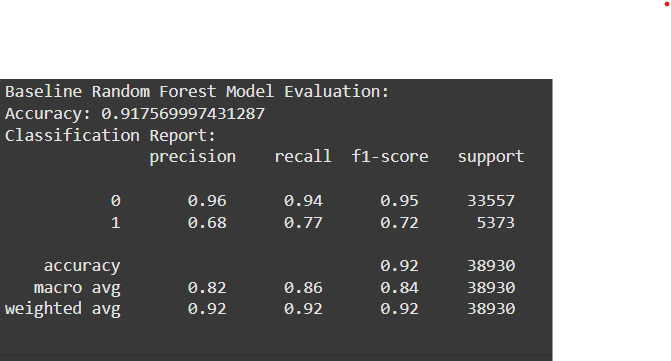

b. Sử dụng Tham số Tối ưu từ RandomizedSearchCV

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Đọc dữ liệu và tiền xử lý
df = pd.read_csv("/content/drive/MyDrive/AI_PROJECT/NEWDATA/data_all_cleaned.csv")

# 2. Loại bỏ các cột không cần thiết
df = df.drop(columns=['datetime', 'Row', 'Col'])

# 3. Gán nhãn cho cột AWS
df['label'] = (df['AWS'] > 0).astype(int)

# 4. Chia dữ liệu thành đầu vào (features) và nhãn (target)
X = df.drop(columns=['label', 'AWS'])
y = df['label']

# 5. Chia dữ liệu thành tập train (70%) và tập tạm thời (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 6. Chia tiếp tập tạm thời thành tập validation (15%) và test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
# Kết quả cuối cùng là: 70% train, 15% validation, 15% test

# 7. Xử lý mất cân bằng lớp bằng SMOTE cho tập train
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# 8. Định nghĩa mô hình Random Forest
rf_model = RandomForestClassifier(random_state=42)

# 9. Thiết lập các giá trị tham số để tinh chỉnh
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 10. Sử dụng RandomizedSearchCV để tìm các tham số tối ưu
search = RandomizedSearchCV(rf_model, param_distributions, n_iter=10, cv=3, scoring='recall', random_state=42, n_jobs=-1)
search.fit(X_train_res, y_train_res)

# 11. Sử dụng mô hình tốt nhất từ RandomizedSearchCV
best_rf_model = search.best_estimator_

# 12. Đánh giá trên tập validation
val_predictions = best_rf_model.predict(X_val)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_val, val_predictions))
print("Classification Report:\n", classification_report(y_val, val_predictions))

# 13. Đánh giá trên tập test
test_predictions = best_rf_model.predict(X_test)
print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, test_predictions))
print("Classification Report:\n", classification_report(y_test, test_predictions))

# 14. In ra các tham số tối ưu
print("Best Parameters:", search.best_params_)


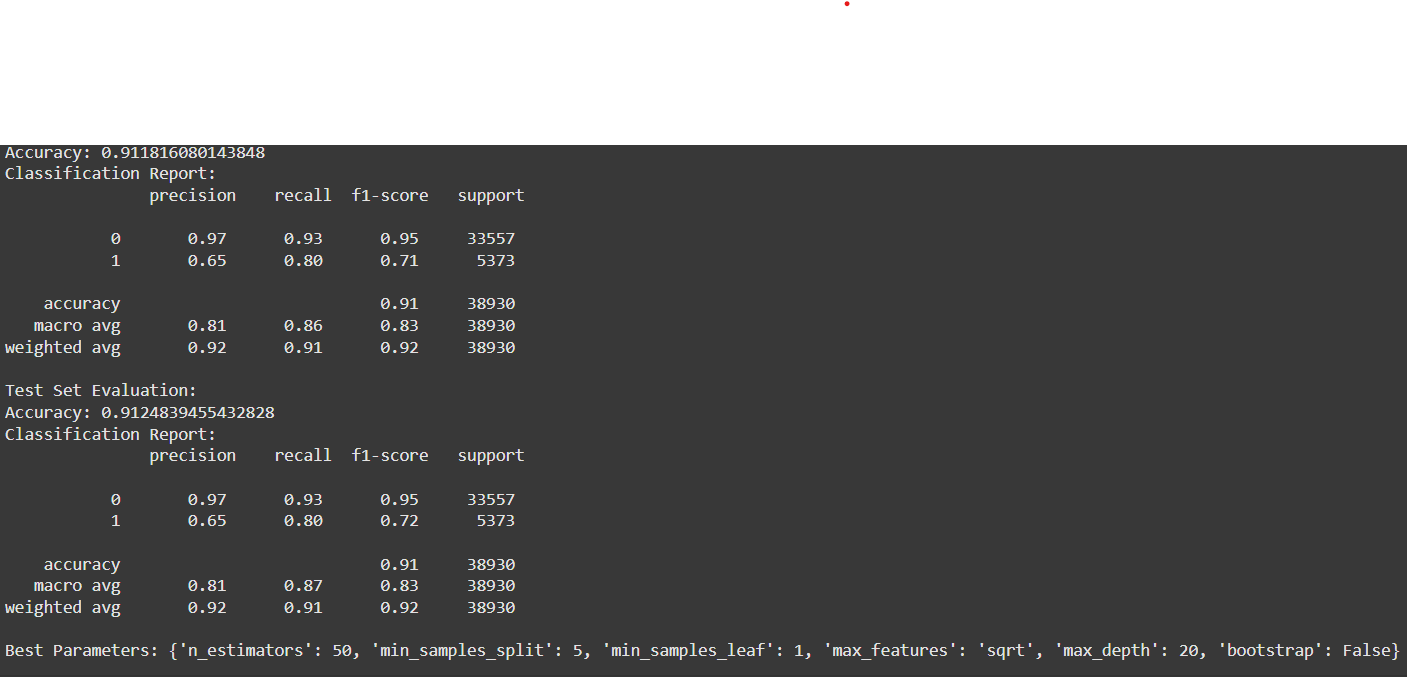

c. Sử dụng Tham số Tối ưu từ RandomizedSearchCV lần 2 với nhiều khoảng tham số hơn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# 1. Đọc dữ liệu từ file CSV
file_path = "/content/drive/MyDrive/DATA/data_all_cleaned.csv"
df = pd.read_csv(file_path)

# 2. Tiền xử lý dữ liệu
df = df.drop(columns=['datetime', 'Row', 'Col'], errors='ignore')  # Loại bỏ các cột không cần thiết
df['label'] = (df['AWS'] > 0).astype(int)  # Gán nhãn: giá trị AWS > 0 là mưa (1), không mưa là 0

# 3. Chia dữ liệu thành đặc trưng và nhãn
X = df.drop(columns=['label', 'AWS'])  # Loại bỏ cột 'label' và 'AWS' khỏi tập đặc trưng
y = df['label']

# 4. Lọc các cột chỉ có kiểu dữ liệu số
X = X.select_dtypes(include=[np.number])

# 5. Chia dữ liệu thành tập train, validation và test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 6. Cân bằng dữ liệu với SMOTE trên tập train
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 7. Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 8. Khởi tạo mô hình RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# 9. Định nghĩa không gian tham số để tìm kiếm với RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt','log2'],
    'bootstrap': [True, False]
}

# 10. Sử dụng RandomizedSearchCV để tìm tham số tốt nhất
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Tìm kiếm tham số tối ưu
random_search.fit(X_train_res, y_train_res)

# Lưu lại tham số tốt nhất
best_params = random_search.best_params_
print("Best parameters from RandomizedSearchCV:", best_params)

# 11. Khởi tạo mô hình với tham số tốt nhất
best_rf_model = RandomForestClassifier(**best_params, random_state=42)

# 12. Huấn luyện mô hình trên dữ liệu đã cân bằng
best_rf_model.fit(X_train_res, y_train_res)

# 13. Đánh giá mô hình trên tập validation
y_val_pred = best_rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

print("Validation Accuracy:", val_accuracy)
print("Validation Classification Report:\n", val_report)

# 14. Đánh giá mô hình trên tập test
y_test_pred = best_rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print("Test Accuracy:", test_accuracy)
print("Test Classification Report:\n", test_report)


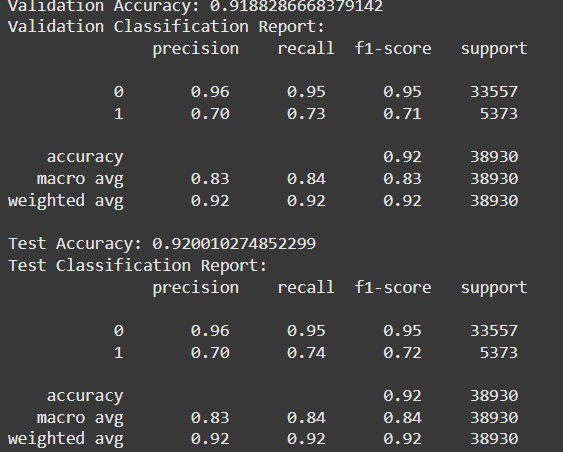

d. Thực nghiệm sử dụng RandomizedSearchCV và class_weight

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Đọc dữ liệu và tiền xử lý
df = pd.read_csv("/content/drive/MyDrive/AI_PROJECT/NEWDATA/data_all_cleaned.csv")

# 2. Loại bỏ các cột không cần thiết
df = df.drop(columns=['datetime', 'Row', 'Col'])

# 3. Gán nhãn cho cột AWS
df['label'] = (df['AWS'] > 0).astype(int)

# 4. Chia dữ liệu thành đầu vào (features) và nhãn (target)
X = df.drop(columns=['label', 'AWS'])
y = df['label']

# 5. Chia dữ liệu thành tập train (70%) và tập tạm thời (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 6. Chia tiếp tập tạm thời thành tập validation (15%) và test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
# Kết quả cuối cùng là: 70% train, 15% validation, 15% test
# 7. Định nghĩa mô hình Random Forest với class_weight='balanced'
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# 8. Thiết lập các giá trị tham số để tinh chỉnh
param_distributions = {
    'n_estimators': [100, 150, 200],
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', {0: 1, 1: 1.5}, {0: 1, 1: 2}]
}

# 9. Sử dụng RandomizedSearchCV để tìm các tham số tối ưu
search = RandomizedSearchCV(rf_model, param_distributions, n_iter=20, cv=3, scoring='recall', random_state=42, n_jobs=-1)
search.fit(X_train, y_train)

# 10. Sử dụng mô hình tốt nhất từ RandomizedSearchCV
best_rf_model = search.best_estimator_

# 11. Đánh giá trên tập validation
val_predictions = best_rf_model.predict(X_val)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_val, val_predictions))
print("Classification Report:\n", classification_report(y_val, val_predictions))

# 12. Đánh giá trên tập test
test_predictions = best_rf_model.predict(X_test)
print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, test_predictions))
print("Classification Report:\n", classification_report(y_test, test_predictions))

# 13. In ra các tham số tối ưu
print("Best Parameters:", search.best_params_)

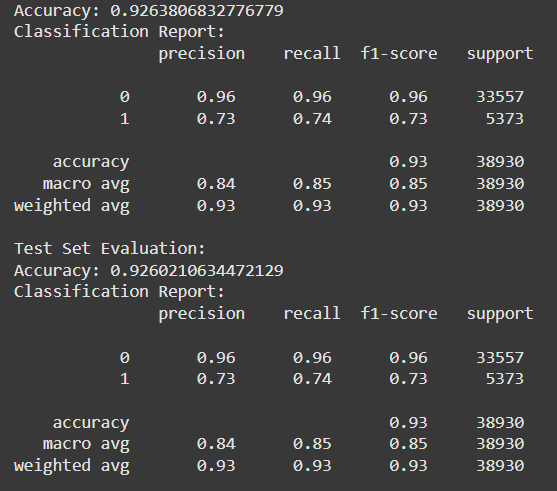

##2.XGBoost

a. Với tham số mặc định


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/drive/MyDrive/DATA/DATA_10-2019/data_all_cleaned.csv')  # Thay đường dẫn của bạn
X = df.drop(columns=['AWS'])  # Giả sử cột 'AWS' là nhãn (mưa: 1, không mưa: 0)
y = df['AWS']

# Chia dữ liệu thành tập huấn luyện (70%), kiểm tra (15%), và validation (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Mô hình XGBoost với các tham số mặc định
xgb_model = XGBClassifier(random_state=42)

# Huấn luyện mô hình trên tập huấn luyện
xgb_model.fit(X_train, y_train)

# Dự đoán trên tập validation
y_pred_val = xgb_model.predict(X_val)

# Đánh giá mô hình trên tập validation
print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, y_pred_val))
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_pred_val))

# Dự đoán trên tập test
y_pred_test = xgb_model.predict(X_test)

# Đánh giá mô hình trên tập test
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test))


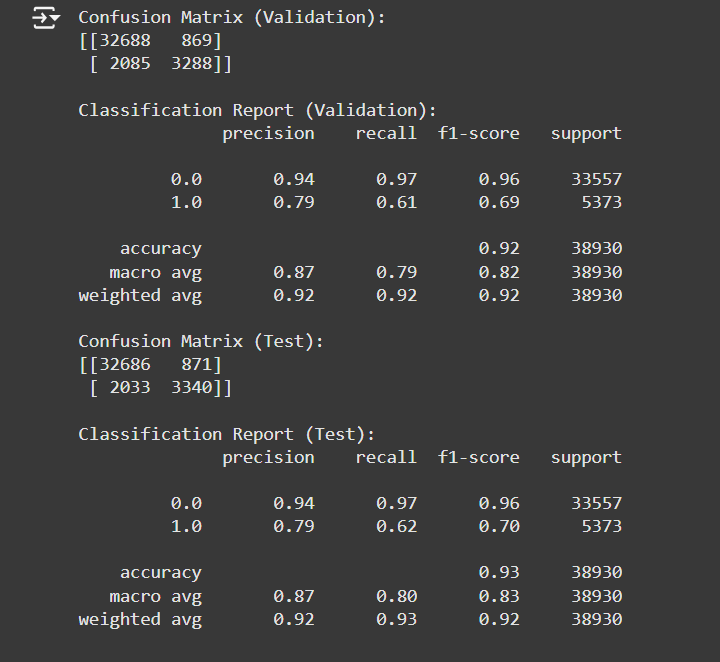

b. XGBoost với SMOTE và tối ưu tham số


In [ ]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/drive/MyDrive/DATA/DATA_10-2019/data_all_cleaned.csv')
X = df.drop(columns=['AWS'])  # cột 'AWS' là nhãn (mưa: 1, không mưa: 0)
y = df['AWS']

# Chia dữ liệu thành tập huấn luyện (70%), kiểm tra (15%), và validation (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Áp dụng SMOTE để cân bằng lớp trong tập huấn luyện
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Mô hình XGBoost với các tham số tối ưu
xgb_model = XGBClassifier(
    objective='binary:logistic',      # Phân loại nhị phân
    max_depth=20,                     # Chiều sâu cây
    min_child_weight=4,               # Trọng số tối thiểu trong mỗi node
    colsample_bytree=0.9,              # Tỷ lệ tính năng sử dụng
    n_estimators=150,                  # Số cây trong mô hình (tăng số cây)
    scale_pos_weight=3,               # Cân bằng lớp (tăng trọng số cho lớp mưa)
    random_state=42,                  # Để tái tạo kết quả
    learn_rate=0.2
)

# Huấn luyện mô hình trên dữ liệu đã được cân bằng
xgb_model.fit(X_train_res, y_train_res)

# Dự đoán xác suất trên tập validation
y_prob_val = xgb_model.predict_proba(X_val)[:, 1]

# Điều chỉnh ngưỡng dự đoán
threshold = 0.8
y_pred_adjusted_val = (y_prob_val >= threshold).astype(int)

# Đánh giá mô hình trên tập validation
print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, y_pred_adjusted_val))
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_pred_adjusted_val))

# Dự đoán trên tập test
y_prob_test = xgb_model.predict_proba(X_test)[:, 1]
y_pred_adjusted_test = (y_prob_test >= threshold).astype(int)

# Đánh giá mô hình trên tập test
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_adjusted_test))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_adjusted_test))


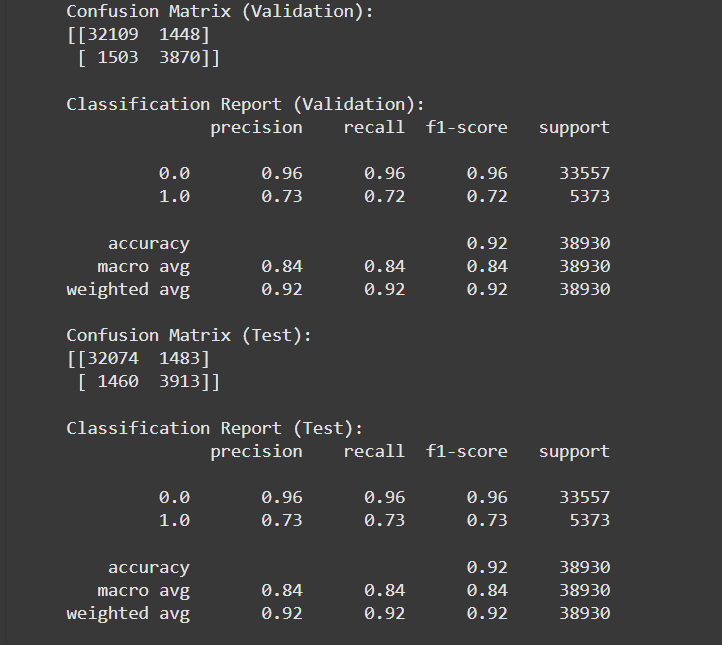

##3.LightGBM

a. Sử dụng tham số mặc định

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

# 1. Đọc dữ liệu và tiền xử lý (có thể chỉ định dtype để tối ưu bộ nhớ)
df = pd.read_csv("/content/drive/MyDrive/DATA/data_all_cleaned.csv", parse_dates=["datetime"])

# 2. Loại bỏ các cột không cần thiết
time_info = df[['datetime', 'Row', 'Col']]

# 3. Gán nhãn cho cột AWS
df['label'] = (df['AWS'] > 0).astype(int)  # Gán nhãn với giá trị AWS > 0 là mưa

# 4. Chia dữ liệu thành đầu vào (features) và nhãn (target)
X = df.drop(columns=['label', 'datetime', 'Row', 'Col', 'AWS'])
y = df['label']

# Chia dữ liệu thành train (70%), validation (15%) và test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# 6. Áp dụng SMOTE để tăng cường dữ liệu cho class 1 (mưa)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Kiểm tra lại tỷ lệ các lớp sau khi sử dụng SMOTE
print(f"Class distribution after SMOTE: {y_train_smote.value_counts()}")

# 7. Khởi tạo mô hình LightGBM với tham số mặc định
lgbm_model = LGBMClassifier(random_state=42)

# 8. Huấn luyện mô hình
lgbm_model.fit(X_train_smote, y_train_smote)

# 9. Đánh giá mô hình trên tập kiểm tra (test set)
lgbm_predictions_test = lgbm_model.predict(X_test)

print("LightGBM Model Evaluation on Test Set:")
print("Test Accuracy:", accuracy_score(y_test, lgbm_predictions_test))
print("Test Classification Report:\n", classification_report(y_test, lgbm_predictions_test))

# 10. Đánh giá mô hình trên tập validation (validation set)
lgbm_predictions_val = lgbm_model.predict(X_val)

print("LightGBM Model Evaluation on Validation Set:")
print("Validation Accuracy:", accuracy_score(y_val, lgbm_predictions_val))
print("Validation Classification Report:\n", classification_report(y_val, lgbm_predictions_val))

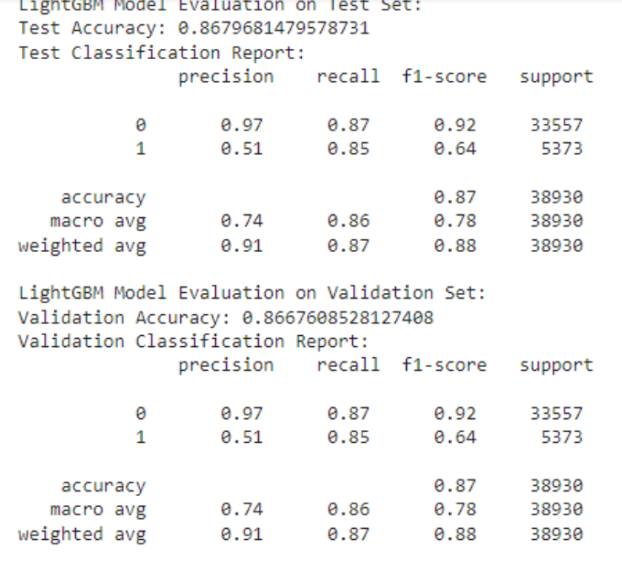

b. Sử dụng RandomizedSearchCV với 10 lần thử nghiệm ngẫu nhiên và 3 lần phân chia trong mỗi lần thử nghiệm

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Đọc dữ liệu và tiền xử lý (có thể chỉ định dtype để tối ưu bộ nhớ)
df = pd.read_csv("/content/drive/MyDrive/DATA/data_all_cleaned.csv", parse_dates=["datetime"])

# 2. Loại bỏ các cột không cần thiết
# df = df.drop(columns=['datetime', 'Row', 'Col'])
time_info = df[['datetime', 'Row', 'Col']]
# 3. Gán nhãn cho cột AWS
df['label'] = (df['AWS'] > 0).astype(int)  # Gán nhãn với giá trị AWS > 0 là mưa

# 4. Chia dữ liệu thành đầu vào (features) và nhãn (target)
X = df.drop(columns=['label','datetime','Row','Col','AWS'])
y = df['label']

# 5. Chia dữ liệu thành tập train và test (80% train, 20% test)
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành train (70%), validation (15%) và test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


# Áp dụng SMOTE để tăng cường dữ liệu cho class 1
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier
import numpy as np

# Các siêu tham số LightGBM
param_dist = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'num_leaves': [31, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [10, 20, 30]
}

# Tuning siêu tham số LightGBM với RandomizedSearchCV
random_search = RandomizedSearchCV(LGBMClassifier(), param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=2, random_state=42)
random_search.fit(X_train_smote, y_train_smote)

# Lấy mô hình tốt nhất
best_model = random_search.best_estimator_

# Dự đoán trên tập kiểm tra (test) và xác nhận (validation)
y_test_pred = best_model.predict(X_test)
y_val_pred = best_model.predict(X_val)

# Đánh giá mô hình trên tập test
print("LightGBM Model Evaluation on Test Set:")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

# Đánh giá mô hình trên tập validation
print("LightGBM Model Evaluation on Validation Set:")
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

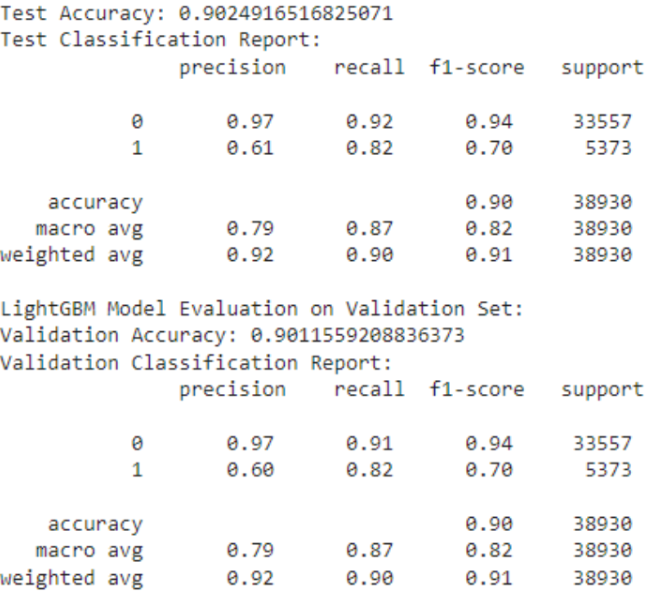

c. Sử dụng RandomizedSearchCV với 20 lần thử nghiệm ngẫu nhiên và 3 lần phân chia trong mỗi lần thử nghiệm

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Đọc dữ liệu và tiền xử lý (có thể chỉ định dtype để tối ưu bộ nhớ)
df = pd.read_csv("/content/drive/MyDrive/DATA/data_all_cleaned.csv", parse_dates=["datetime"])

# 2. Loại bỏ các cột không cần thiết
time_info = df[['datetime', 'Row', 'Col']]

# 3. Gán nhãn cho cột AWS
df['label'] = (df['AWS'] > 0).astype(int)  # Gán nhãn với giá trị AWS > 0 là mưa

# 4. Chia dữ liệu thành đầu vào (features) và nhãn (target)
X = df.drop(columns=['label','datetime','Row','Col','AWS'])
y = df['label']


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# 6. Áp dụng SMOTE để tăng cường dữ liệu cho class 1 (mưa)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Kiểm tra lại tỷ lệ các lớp sau khi sử dụng SMOTE
print(f"Class distribution after SMOTE: {y_train_smote.value_counts()}")

# 7. Khởi tạo mô hình LightGBM và áp dụng RandomizedSearchCV để tối ưu tham số
lgbm_model = LGBMClassifier(random_state=42)

# Định nghĩa các tham số để tối ưu
param_dist = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 5, 10],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Áp dụng RandomizedSearchCV để tìm tham số tối ưu
random_search = RandomizedSearchCV(lgbm_model, param_distributions=param_dist,
                                   n_iter=20, scoring='f1',
                                   cv=3, verbose=2, random_state=42)

# Huấn luyện mô hình với SMOTE và tối ưu tham số
random_search.fit(X_train_smote, y_train_smote)

# Lấy mô hình tốt nhất từ RandomizedSearchCV
best_model = random_search.best_estimator_

# 8. Đánh giá mô hình trên tập kiểm tra (test set)
lgbm_predictions_test = best_model.predict(X_test)

# Đánh giá mô hình trên tập test
print("LightGBM Model Evaluation on Test Set:")
print("Test Accuracy:", accuracy_score(y_test, lgbm_predictions_test))
print("Test Classification Report:\n", classification_report(y_test, lgbm_predictions_test))

# Đánh giá mô hình trên tập validation (validation set)/-strong/-heart:>:o:-((:-h lgbm_predictions_val = best_model.predict(X_val)

# Đánh giá mô hình trên tập validation
print("LightGBM Model Evaluation on Validation Set:")
print("Validation Accuracy:", accuracy_score(y_val, lgbm_predictions_val))
print("Validation Classification Report:\n", classification_report(y_val, lgbm_predictions_val))

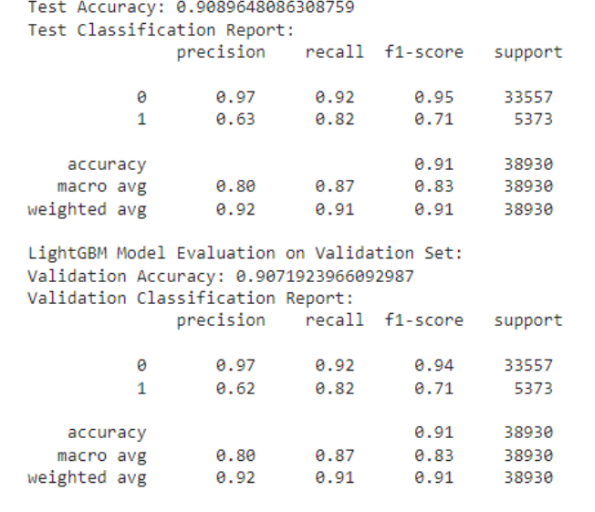